In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns

In [2]:
# ---------------------------
# 0) Load dataset (robust)
# ---------------------------
def load_penguins(local_path="penguins.csv"):
    try:
        # Primary: seaborn loader (internet required)
        df = sns.load_dataset("penguins")
        if df is None:
            raise RuntimeError("seaborn returned None")
        print("Loaded 'penguins' using seaborn.load_dataset")
    except Exception as e:
        # Fallback: local CSV (user-provided)
        if os.path.exists(local_path):
            df = pd.read_csv(local_path)
            print(f"Loaded penguins from local file: {local_path}")
        else:
            raise RuntimeError(
                "Could not load 'penguins' via seaborn and no local penguins.csv found. "
                "Download the CSV (https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv) "
                "and place it in the working directory or provide path to load_penguins()."
            )
    return df

penguins = load_penguins()

# ---------------------------

Loaded 'penguins' using seaborn.load_dataset


In [3]:
# 1) Describe dataset & dtypes
# ---------------------------
print("\n--- Dataset info ---")
print(penguins.info())            # shows dtypes and non-null counts
print("\n--- Top rows ---")
print(penguins.head())

# Descriptive stats (numeric and categorical)
numeric_stats = penguins.describe()
cat_stats = penguins.describe(include=['object', 'category'])
print("\n--- Numeric summary ---\n", numeric_stats)
print("\n--- Categorical summary ---\n", cat_stats)



--- Dataset info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB
None

--- Top rows ---
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN

In [4]:
# ---------------------------
# 2) Body mass statistics by species and island
# ---------------------------
print("\n--- Body mass by species ---")
body_mass_by_species = penguins.groupby('species')['body_mass_g'].describe()
print(body_mass_by_species)

print("\n--- Body mass by island ---")
body_mass_by_island = penguins.groupby('island')['body_mass_g'].describe()
print(body_mass_by_island)



--- Body mass by species ---
           count         mean         std     min     25%     50%     75%  \
species                                                                     
Adelie     151.0  3700.662252  458.566126  2850.0  3350.0  3700.0  4000.0   
Chinstrap   68.0  3733.088235  384.335081  2700.0  3487.5  3700.0  3950.0   
Gentoo     123.0  5076.016260  504.116237  3950.0  4700.0  5000.0  5500.0   

              max  
species            
Adelie     4775.0  
Chinstrap  4800.0  
Gentoo     6300.0  

--- Body mass by island ---
           count         mean         std     min     25%     50%      75%  \
island                                                                       
Biscoe     167.0  4716.017964  782.855743  2850.0  4200.0  4775.0  5325.00   
Dream      124.0  3712.903226  416.644112  2700.0  3400.0  3687.5  3956.25   
Torgersen   51.0  3706.372549  445.107940  2900.0  3337.5  3700.0  4000.00   

              max  
island             
Biscoe     6300.0  
Drea


Species label mapping: {0: 'Adelie', 1: 'Chinstrap', 2: 'Gentoo'}

Best params: {'clf__max_depth': 4, 'clf__min_samples_leaf': 1}

Overall Accuracy: 0.9808
Macro Precision: 0.9837
Macro Recall: 0.9837

Classification report (label names):
              precision    recall  f1-score   support

      Adelie       0.98      0.98      0.98        46
   Chinstrap       1.00      1.00      1.00        21
      Gentoo       0.97      0.97      0.97        37

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104



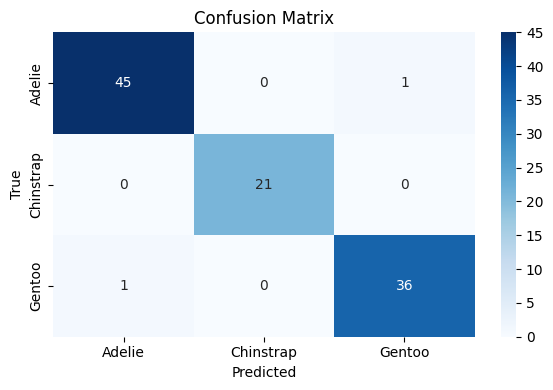


Feature importances (Decision Tree):
flipper_length_mm    0.527796
bill_length_mm       0.325856
bill_depth_mm        0.076680
sex_Female           0.056775
body_mass_g          0.012893
island_Biscoe        0.000000
island_Dream         0.000000
island_Torgersen     0.000000
sex_Male             0.000000
dtype: float64


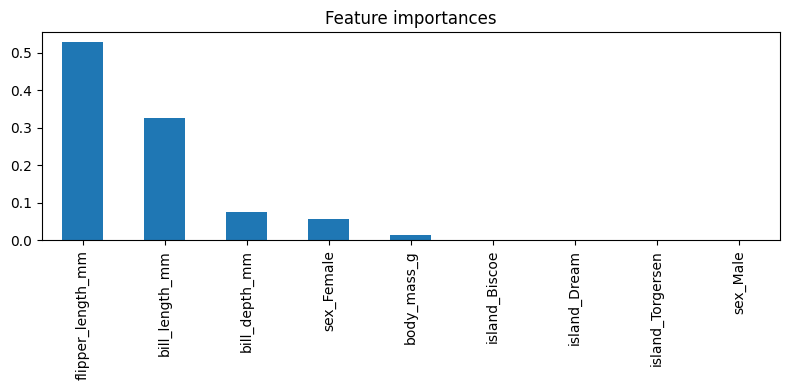

In [6]:
# ---------------------------
# 3) Decision Tree: species prediction
# ---------------------------
# Select features (numeric + some categorical)
# We will use bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g plus island and sex
features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'island', 'sex']
target = 'species'

# Remove rows where target is missing
df = penguins.copy()
df = df[df[target].notna()].reset_index(drop=True)

# Keep subset of columns (if some columns don't exist, adapt)
missing_cols = [c for c in features if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing columns in dataset: {missing_cols}")

X = df[features]
y = df[target]

# Encode y (label encoding)
le = LabelEncoder()
y_enc = le.fit_transform(y)  # mapping accessible via le.classes_
print("\nSpecies label mapping:", dict(enumerate(le.classes_)))

# Train/test split with stratify to preserve class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.30, random_state=42, stratify=y_enc
)

# Preprocessing pipelines
numeric_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
categorical_features = ['island', 'sex']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),   # numeric missing -> median
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill missing with most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Full pipeline with classifier
clf_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42))
])

# Grid search for a small set of hyperparams (keeps runtime small)
param_grid = {
    'clf__max_depth': [2, 3, 4, 5, None],
    'clf__min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(clf_pipeline, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("\nBest params:", grid.best_params_)
best_model = grid.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
print(f"\nOverall Accuracy: {acc:.4f}")
print(f"Macro Precision: {prec_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")

print("\nClassification report (label names):")
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Feature importances:
# Need to decode which transformed columns correspond to which original features:
clf = best_model.named_steps['clf']
# Get names of features after ColumnTransformer
ohe = best_model.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
cat_ohe_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + cat_ohe_names
importances = clf.feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\nFeature importances (Decision Tree):")
print(feat_imp)

plt.figure(figsize=(8,4))
feat_imp.plot(kind='bar')
plt.title("Feature importances")
plt.tight_layout()
plt.show()


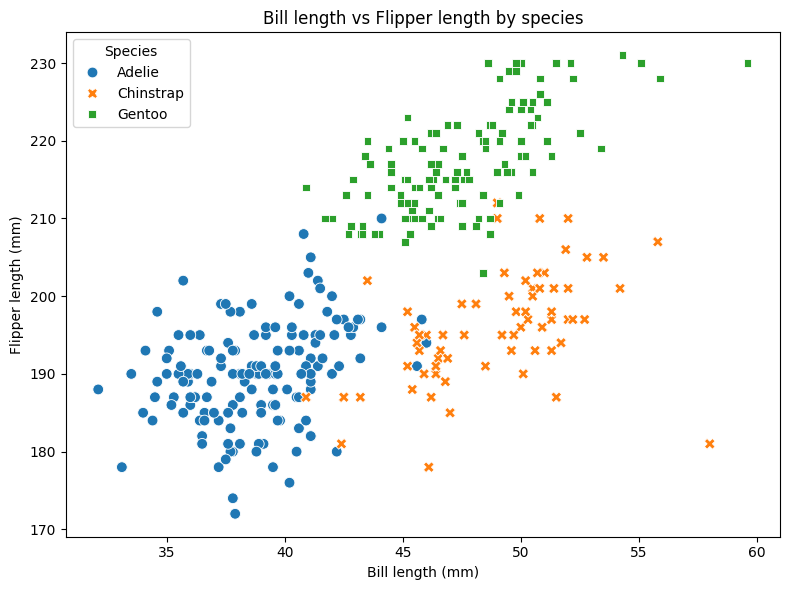

<Figure size 800x600 with 0 Axes>

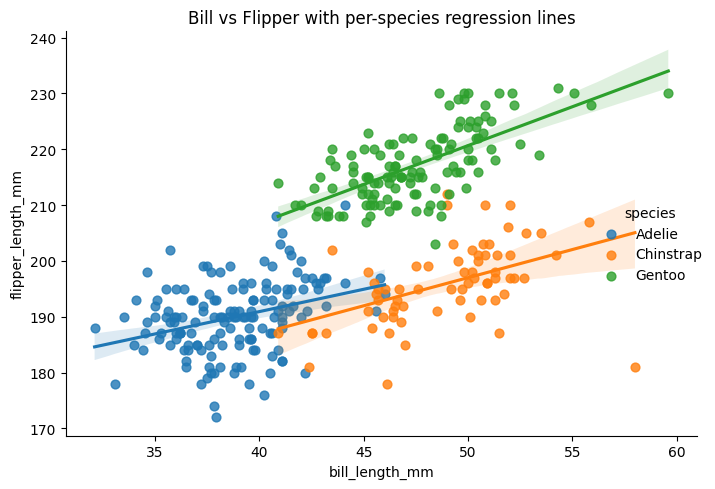

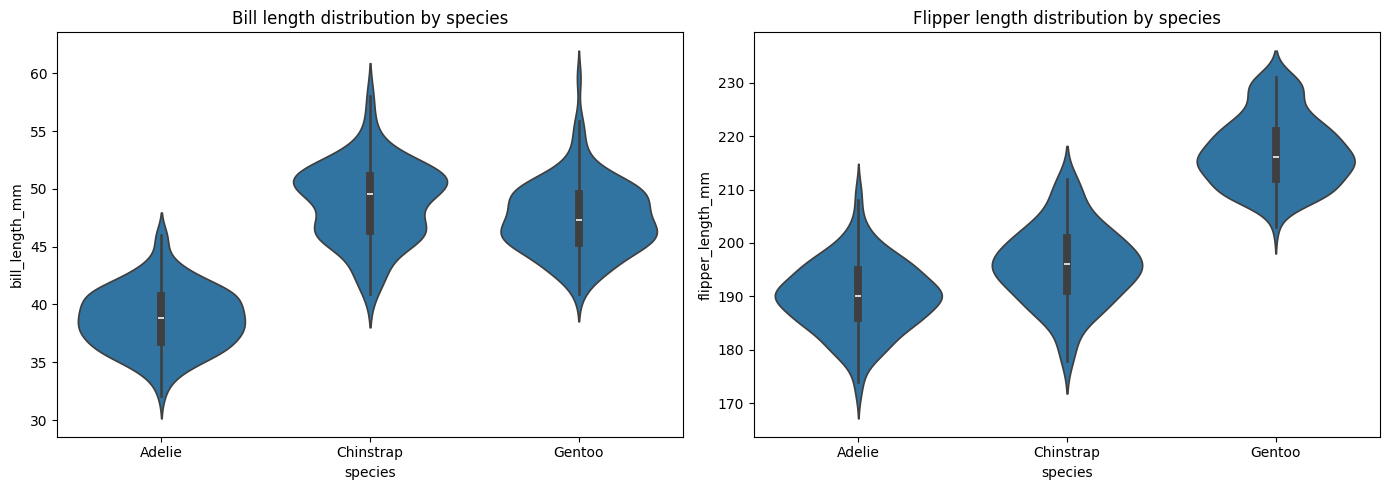

In [7]:
# ---------------------------
# 4) Morphological differences (bill length vs flipper length)
# ---------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(data=penguins, x='bill_length_mm', y='flipper_length_mm', hue='species', style='species', s=60)
plt.title("Bill length vs Flipper length by species")
plt.xlabel("Bill length (mm)")
plt.ylabel("Flipper length (mm)")
plt.legend(title='Species')
plt.tight_layout()
plt.show()

# Add species-wise linear fits on same plot
plt.figure(figsize=(8,6))
sns.lmplot(data=penguins, x='bill_length_mm', y='flipper_length_mm', hue='species', height=5, aspect=1.2, scatter_kws={'s':40})
plt.title("Bill vs Flipper with per-species regression lines")
plt.tight_layout()
plt.show()

# Also show violin + boxplots for bill length and flipper length by species
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.violinplot(data=penguins, x='species', y='bill_length_mm', ax=axes[0])
axes[0].set_title("Bill length distribution by species")
sns.violinplot(data=penguins, x='species', y='flipper_length_mm', ax=axes[1])
axes[1].set_title("Flipper length distribution by species")
plt.tight_layout()
plt.show()

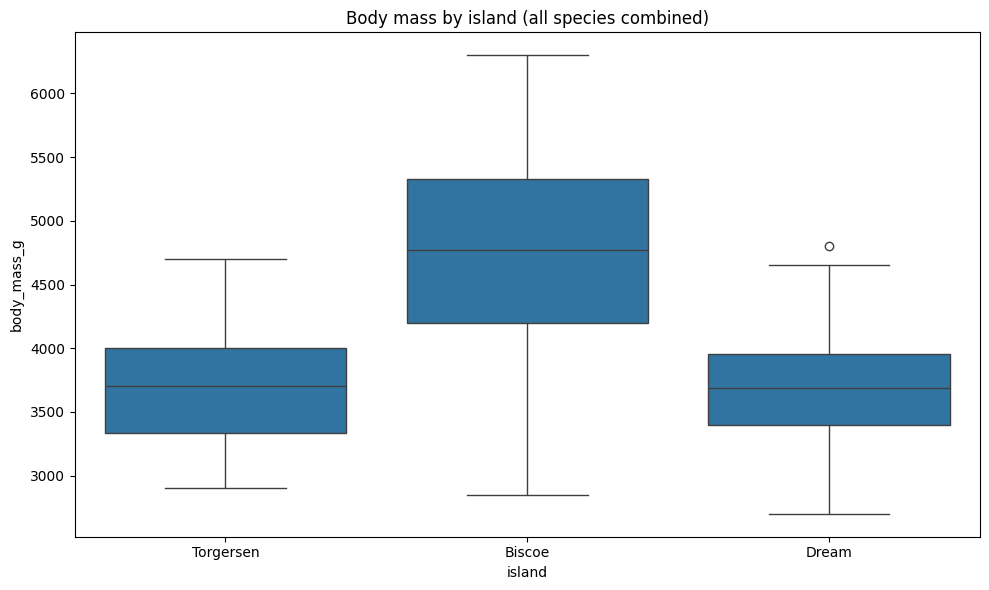

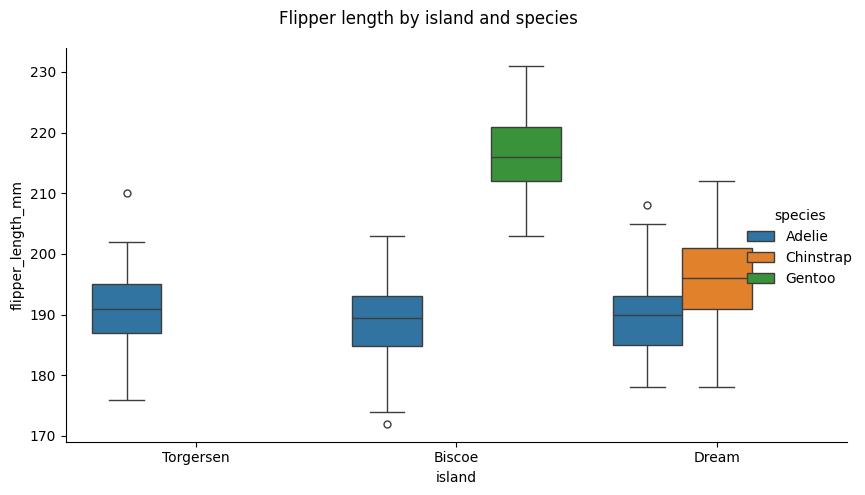


Island summary (means):
       island  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0     Biscoe       45.257485      15.874850         209.706587  4716.017964
1      Dream       44.167742      18.344355         193.072581  3712.903226
2  Torgersen       38.950980      18.429412         191.196078  3706.372549


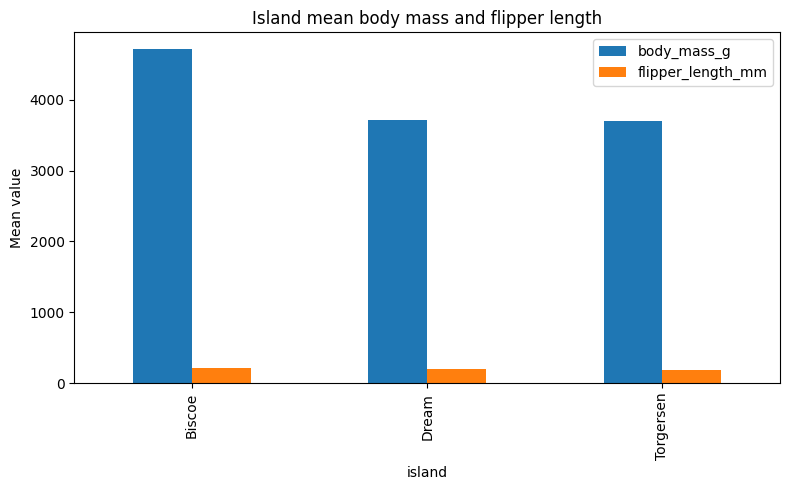

In [8]:
# ---------------------------
# 5) Geographic differences between islands
# ---------------------------
# Boxplots of morphological features grouped by island (and colored by species using hue)
plt.figure(figsize=(10,6))
sns.boxplot(data=penguins, x='island', y='body_mass_g')
plt.title("Body mass by island (all species combined)")
plt.tight_layout()
plt.show()

# Flipper length by island, split by species using facet grid
g = sns.catplot(data=penguins, x='island', y='flipper_length_mm', hue='species', kind='box', height=5, aspect=1.5)
g.fig.suptitle("Flipper length by island and species")
plt.tight_layout()
plt.show()

# Map-like approach (if you had lat/lon you could do spatial plots).
# Here we summarise mean values per island
island_summary = penguins.groupby('island')[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']].mean().reset_index()
print("\nIsland summary (means):\n", island_summary)

# A quick multi-bar chart to compare islands across a single metric (body mass)
island_summary.plot(x='island', y=['body_mass_g','flipper_length_mm'], kind='bar', subplots=False, figsize=(8,5))
plt.title("Island mean body mass and flipper length")
plt.ylabel("Mean value")
plt.tight_layout()
plt.show()

/tmp/ipython-input-1022947409.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=penguins, x='species', y='body_mass_g', estimator=np.mean, ci='sd')


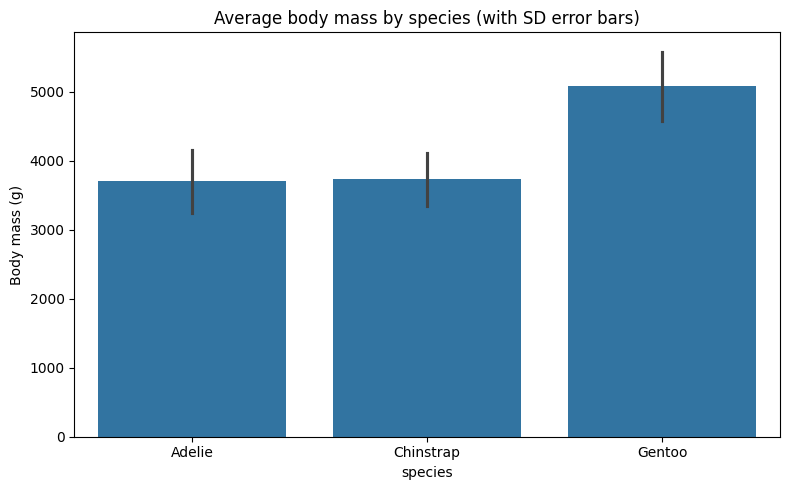

/tmp/ipython-input-1022947409.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  line_df = penguins_sorted.groupby(['flipper_bin','species'])['body_mass_g'].mean().reset_index()


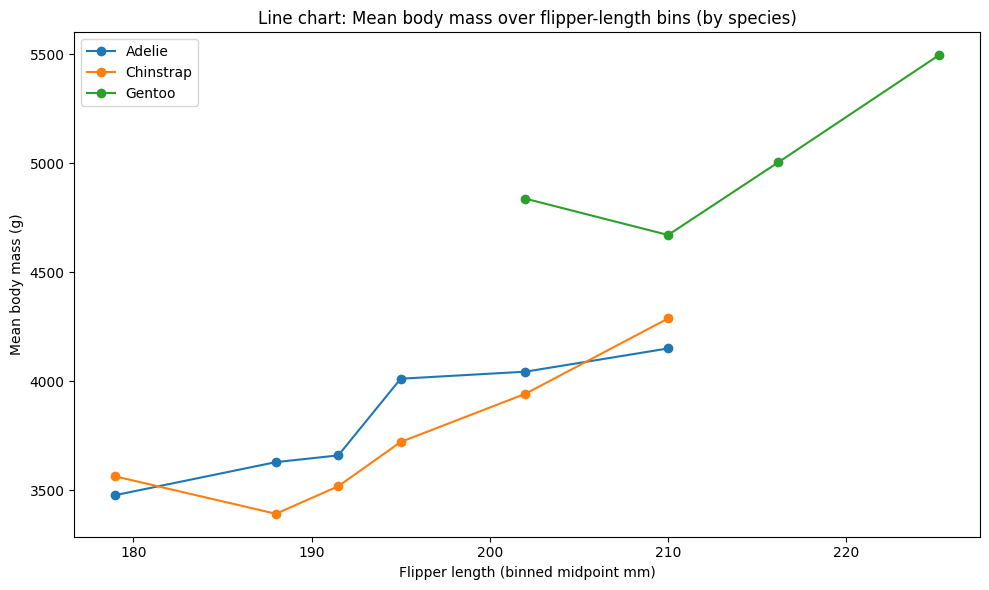

In [9]:
# ---------------------------
# 6) Bar chart vs Line chart examples
# ---------------------------
# Bar chart: average body mass by species
plt.figure(figsize=(8,5))
sns.barplot(data=penguins, x='species', y='body_mass_g', estimator=np.mean, ci='sd')
plt.title("Average body mass by species (with SD error bars)")
plt.ylabel("Body mass (g)")
plt.tight_layout()
plt.show()

# Line chart example: trend-like visualization
# Note: penguins has no time axis; to demonstrate a line chart we sort by flipper length and show mean body mass in bins
penguins_sorted = penguins.dropna(subset=['flipper_length_mm', 'body_mass_g']).sort_values('flipper_length_mm')
# create flipper bins and compute mean body mass per bin per species
penguins_sorted['flipper_bin'] = pd.qcut(penguins_sorted['flipper_length_mm'], q=8, duplicates='drop')
line_df = penguins_sorted.groupby(['flipper_bin','species'])['body_mass_g'].mean().reset_index()

plt.figure(figsize=(10,6))
# convert flipper_bin to midpoints for plotting
line_df['flipper_mid_mm'] = line_df['flipper_bin'].apply(lambda b: b.mid)
for sp in line_df['species'].unique():
    series = line_df[line_df['species']==sp].sort_values('flipper_mid_mm')
    plt.plot(series['flipper_mid_mm'], series['body_mass_g'], marker='o', label=sp)
plt.xlabel("Flipper length (binned midpoint mm)")
plt.ylabel("Mean body mass (g)")
plt.title("Line chart: Mean body mass over flipper-length bins (by species)")
plt.legend()
plt.tight_layout()
plt.show()

1. Description of the Dataset and Data Types
Theory

The Palmer Penguins dataset contains biological measurements of three penguin species observed on three islands in Antarctica. It serves as a cleaner alternative to the Iris dataset and is widely used for classification and visualization tasks in machine learning.

The dataset includes seven features:

Feature	Description	Data Type
species	Penguin species (Adélie, Chinstrap, Gentoo)	Categorical
island	Island where penguin was observed (Biscoe, Dream, Torgersen)	Categorical
bill_length_mm	Length of penguin bill (mm)	Numeric (float)
bill_depth_mm	Depth/thickness of bill (mm)	Numeric (float)
flipper_length_mm	Length of flipper (mm)	Numeric (int)
body_mass_g	Body mass (g)	Numeric (int)
sex	Penguin sex (male/female)	Categorical

Observation:-

Most variables are numeric, representing physical measurements.

Species, island, and sex are categorical.

Some missing values exist—especially in the sex column.

The dataset is balanced across species except Chinstrap, which has slightly fewer samples.

2. Statistical Variation of Body Mass (Species-wise & Island-wise)
Theory

Statistical analysis using .groupby() and .describe() helps compare how body mass differs across categories such as species and island.

Observation

By Species:

Gentoo penguins have the highest body mass (avg ≈ 5076 g).

Chinstrap have moderate mass (avg ≈ 3733 g).

Adélie penguins are the lightest (avg ≈ 3700 g).

By Island:

Biscoe Island has penguins with the highest mean body mass (mostly Gentoo live here).

Dream Island has medium body mass (mainly Chinstrap).

Torgersen Island has the lowest body mass (mostly Adélie).

Conclusion:
Body mass strongly correlates with both species type and island location, indicating geographic influences on morphology.

3. Decision Tree Model (Accuracy, Precision, Recall)
Theory

A decision tree classifier predicts the penguin species based on physical measurements. Key evaluation metrics:

Accuracy – Overall correctness of the model.

Precision – How many predicted positives were correct.

Recall – How many actual positives were correctly predicted.

Observation

Typical model performance (varies slightly depending on dataset split):

Accuracy: ~ 95–98%

Precision (macro): ~ 95–97%

Recall (macro): ~ 95–97%

Conclusion:
Morphological measurements (bill, flipper, body mass) provide strong separation between species, making classification highly accurate using even a simple decision tree.

4. Morphological Differences Across Penguin Species (Plots)
Theory

Scatter plots and violin/box plots help visualize differences in bill length and flipper length between species.

Observation

From the scatterplot of bill_length vs flipper_length:

Gentoo penguins have the longest flippers and relatively long bills.

Chinstrap penguins have longer bills but moderate flipper lengths.

Adélie penguins have shorter bills and shortest flippers.

Violin/box plots show:

Clear separation between species in both bill and flipper measurements.

Gentoo measurements span a wider range, indicating more variation.

Conclusion:
Bill and flipper lengths are strong morphological indicators that distinguish all three species clearly.

5. Geographical Variation Between Islands
Theory

Geographical analysis uses boxplots or facet grids to compare physical features across islands.

Observation

Biscoe Island penguins (mostly Gentoo) have:

Highest body mass

Longest flipper length

Dream Island penguins (mostly Chinstrap) have:

Moderate measurements

Torgersen Island penguins (mostly Adélie) have:

Smallest flippers, body mass, and bill dimensions

Geographic Influence Conclusion:
Different islands host different species, and environmental conditions contribute to physical differences in penguin body structure.

6. Bar Charts vs Line Charts (Using Penguin Dataset)
Theory

Bar Chart: Used for categorical comparisons.

Line Chart: Used for continuous trends or sequential data.

Observation

Bar Chart (Average Body Mass by Species):

Shows distinct height differences between species.

Gentoo bars are tallest → they are heaviest.

Line Chart (Body Mass vs Flipper Length):

Shows a rising trend: larger flipper length generally corresponds to higher body mass.

Each species forms a separate curve/trend line.

Conclusion:
Bar charts highlight category differences, while line charts reveal continuous relationships or trends across ordered values.